In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from pylab import rcParams
rcParams['figure.figsize'] = 5, 4
rcParams['figure.dpi'] = 200

import torch

from sklearn import cluster, datasets, mixture
from sklearn.preprocessing import StandardScaler

In [2]:
from scipy.spatial import distance_matrix

In [3]:
n1 = 50

In [4]:
V = 50000

In [5]:
d0 = 5

In [6]:
cutoff_list = list()
for l in range(d0):
    cutoff_list+= [np.sort([np.random.randint(n1,high=n1*2),np.random.randint(2*n1,high=n1*3)])]

In [7]:
x0 = np.random.randint(0,high=d0,size=V)

In [8]:
dtype = torch.float

In [9]:
S_list = list()

for v in range(V):
    
    Y = np.random.normal(0,1,[n1*3,2])

    cutoffs = cutoff_list[x0[v]]
    
    Y[cutoffs[0]:cutoffs[1],] -= 2
    Y[cutoffs[1]:,] += 2

    n = Y.shape[0]
    D = torch.zeros(n,n)

    D = distance_matrix(Y,Y,p=2)

    # use 30% quantile of each row as the bandwidth
    b = np.sqrt(np.quantile(D,0.3,  axis=0))

    S = np.exp(- (D/b).T/b)

    S_list.append(S)

In [10]:
cutoff_list

[array([ 87, 140]),
 array([ 95, 108]),
 array([ 52, 120]),
 array([ 80, 126]),
 array([ 83, 114])]

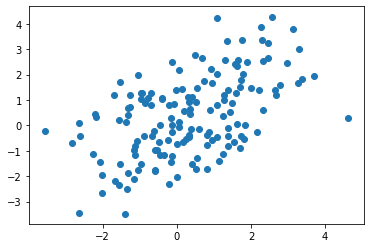

In [11]:
plt.scatter(Y[:,0],Y[:,1])

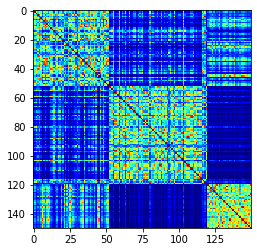

In [12]:
plt.imshow(S_list[0], cmap="jet")

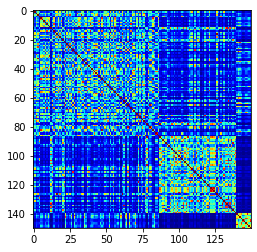

In [13]:
plt.imshow(S_list[4], cmap="jet")

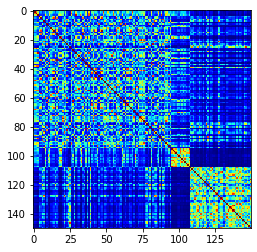

In [14]:
plt.imshow(S_list[V-1], cmap="jet")

In [15]:
# plt.plot(S[n1*2])

In [16]:
g = 10

In [17]:
d = 10

In [18]:
device = torch.device(device= 'cuda:1')

# device = torch.device(device= 'cpu')

In [19]:
# initialize eta with K-means

ltri_idx = np.tril_indices(n,k=-1)

logs_mat = np.zeros([V, int(n*(n-1)/2)])
s_mat = np.zeros([V, int(n*(n-1)/2)])

for v in range(V):
    s_mat[v] = (S_list[v][ltri_idx])

logs_mat = np.log(s_mat)
    
from sklearn.cluster import KMeans

km_fit= KMeans(d).fit(logs_mat).labels_

from sklearn.preprocessing import OneHotEncoder

eta_ini = np.eye(d)[km_fit]

# smoothing
eta_ini = (eta_ini + 1/V) / (1+ d/V)

# eta_ini_dev = torch.tensor(eta_ini,device=device,dtype=dtype)

In [20]:
eta = eta_ini

In [21]:
lam = np.ones(d)
lam = lam/np.sum(lam)

In [22]:
lam

array([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1])

In [23]:
from sklearn.metrics import normalized_mutual_info_score

In [24]:
normalized_mutual_info_score(km_fit, x0)

/home/shared/anaconda3/envs/leo/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


0.8367448666859272

In [25]:
eta_S = eta.T@ s_mat
eta_1MinusS = eta.T@ (1-s_mat)

EtaS_list = list()
Eta1MinusS_list = list()

for l in range(d):
    EtaS_list.append( torch.tensor(eta_S[l], dtype=dtype, device=device))
    Eta1MinusS_list.append(torch.tensor(eta_1MinusS[l], dtype=dtype, device=device))

In [26]:
W0_list = list()

for l in range(d):
    W0 = torch.rand(n,g, requires_grad=True, device = device, dtype=dtype)
    W0_list.append(W0)

In [27]:
def CrossEntropyTorch(S_ltr, S1m_ltr,P_ltr):
    CEntropy = - S_ltr * torch.log(P_ltr) - S1m_ltr * torch.log(1-P_ltr)
    loss = torch.sum(CEntropy)
    return loss

In [28]:
def CrossEntropyNumpy(S, P):
    CEntropy = - S * np.log(P) - (1-S) * np.log(1-P)
    loss = np.sum(CEntropy)
    return loss

In [29]:
ltri_idx_torch = torch.tril(torch.ones(n, n),diagonal=-1) == 1

In [ ]:
# W_list = list()
# P_list = list()

# for l in range(d):
#     W = torch.softmax(W0_list[l],1)
#     P = W@W.T

#     W_list.append(W)
#     P_list.append(P)

# loss = 0
# for l in range(d):
#     W = W_list[l]
#     loss += CrossEntropy(EtaS_list[l], Eta1MinusS_list[l], (W@W.T)[ltri_idx_torch])

# loss

In [31]:
# def CrossEntropy_slow(S,P):

#     CEntropy = - S * torch.log(P) - (1-S)* torch.log(1-P)
#     loss = torch.sum(torch.tril(CEntropy, diagonal=-1))
#     return loss

# eta_ini_dev = torch.tensor(eta_ini,device=device,dtype=dtype)
# loss_mat = torch.zeros(V,d ,device=device)

# W_list = list()
# P_list = list()

# for l in range(d):
#     W = torch.softmax(W0_list[l],1)
#     P = W@W.T

#     W_list.append(W)
#     P_list.append(P)

# for v in range(V):
#     for l in range(d):
#         loss_mat[v,l] = CrossEntropy_slow(torch.tensor(S_list[v],device=device,dtype=dtype),P_list[l])

# eta = eta_ini_dev #torch.ones_like(loss_mat, device=device, dtype=dtype)/ d

# torch.sum(eta * loss_mat)

In [32]:
alpha0 = 0.1

In [33]:
tau = 1

In [34]:
learning_rate = 1
optimizer = torch.optim.Adam(W0_list, lr=learning_rate)

In [35]:
from copy import deepcopy 

In [36]:
for t in range(200):
    
    W_list = list()
    P_list = list()

    for l in range(d):
        W = torch.softmax(W0_list[l],1)
        P = W@W.T

        W_list.append(W)
        P_list.append(P)

    loss = 0
    for l in range(d):
        W = W_list[l]
        loss += CrossEntropyTorch(EtaS_list[l], Eta1MinusS_list[l], P_list[l][ltri_idx_torch])
    
    
#     eta = eta_ini_dev #torch.ones_like(loss_mat, device=device, dtype=dtype)/ d
    l21_penalty = 0    
    
    for l in range(d):
        l21_penalty += tau * torch.sum(torch.sqrt(torch.sum( torch.threshold(torch.log(W_list[l])+3.0,0.0,0.0)**2,0)))    
    
    total_loss =    loss/n + l21_penalty
    
    
    if t % 100 ==0:
        print(t, total_loss.item(), lam)
#         print(eta)

    # Before the backward pass, use the optimizer object to zero all of the
    # gradients for the Tensors it will update (which are the learnable weights
    # of the model)
    optimizer.zero_grad()

    # Backward pass: compute gradient of the loss with respect to model parameters
    total_loss.backward()

    # Calling the step function on an Optimizer makes an update to its parameters
    optimizer.step()

0 2731058.0 [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
100 2110669.5 [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]


In [37]:
s_mat.shape

(50000, 11175)

In [38]:
len(P_list)

10

In [39]:
def np_softmax_each_row(x):
    mx = np.max(x, axis=-1, keepdims=True)
    x - mx
    # array([[-1,  0],
    #        [-1,  0]])
    numerator = np.exp(x - mx)
    denominator = np.sum(numerator, axis=-1, keepdims=True)
    denominator
    # array([[ 1.36787944],
    #        [ 1.36787944]])
    return numerator/denominator

In [40]:
# Compute Eta

loss_mat = np.zeros([V,d])

for v in range(V):
    for l in range(d):
        P_cpu = (P_list[l][ltri_idx_torch]).detach().cpu().numpy()
        loss_mat[v,l] = CrossEntropyNumpy(s_mat[v],P_cpu)

eta = np_softmax_each_row(- loss_mat + np.log(lam))


eta_S = eta.T@ s_mat
eta_1MinusS = eta.T@ (1-s_mat)

EtaS_list = list()
Eta1MinusS_list = list()

for l in range(d):
    EtaS_list.append( torch.tensor(eta_S[l], dtype=dtype, device=device))
    Eta1MinusS_list.append(torch.tensor(eta_1MinusS[l], dtype=dtype, device=device))

optimizer.zero_grad()


In [41]:
eta.sum(0)

array([3282.43699832, 9003.7076684 , 4430.48770511, 2713.01361536,
        968.2923316 ,  591.73999078, 6593.56300168, 9561.26000922,
       7321.98638464, 5533.51229489])

In [42]:
# Compute Lam:

lam = (eta.sum(0)+alpha0-1)/(eta.sum() + alpha0*d - d)
lam[lam<0] = 1E-5
lam /= np.sum(lam)

In [43]:
learning_rate = 0.1
optimizer = torch.optim.Adam(W0_list, lr=learning_rate)

In [44]:
for t in range(200):
    
    W_list = list()
    P_list = list()

    for l in range(d):
        W = torch.softmax(W0_list[l],1)
        P = W@W.T

        W_list.append(W)
        P_list.append(P)

    loss = 0
    for l in range(d):
        W = W_list[l]
        loss += CrossEntropyTorch(EtaS_list[l], Eta1MinusS_list[l], P_list[l][ltri_idx_torch])
    
    
#     eta = eta_ini_dev #torch.ones_like(loss_mat, device=device, dtype=dtype)/ d
    l21_penalty = 0    
    
    for l in range(d):
        l21_penalty += tau * torch.sum(torch.sqrt(torch.sum( torch.threshold(torch.log(W_list[l])+3.0,0.0,0.0)**2,0)))    
    
    total_loss =    loss/n + l21_penalty
    
    if t % 100 ==0:
        print(t, total_loss.item() )
#         print(eta)

    # Before the backward pass, use the optimizer object to zero all of the
    # gradients for the Tensors it will update (which are the learnable weights
    # of the model)
    optimizer.zero_grad()

    # Backward pass: compute gradient of the loss with respect to model parameters
    total_loss.backward()

    # Calling the step function on an Optimizer makes an update to its parameters
    optimizer.step()

0 2109693.25
100 2107621.25


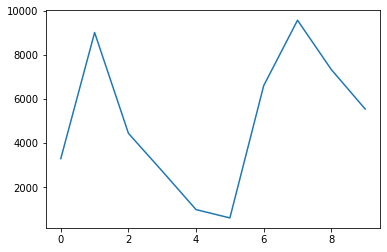

In [45]:
plt.plot( np.sum(eta,0))

In [46]:
lam

array([0.06564256, 0.18008857, 0.0886077 , 0.05425204, 0.01935133,
       0.01181893, 0.131877  , 0.19124162, 0.14644809, 0.11067217])

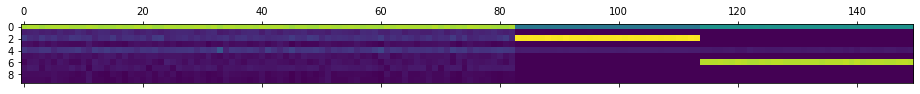

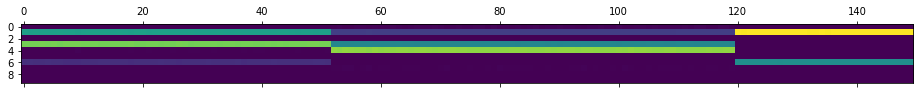

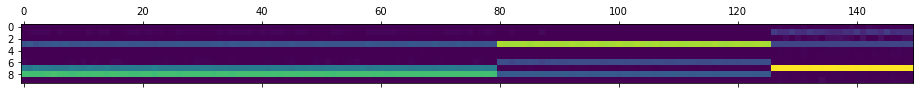

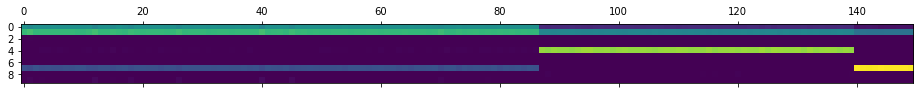

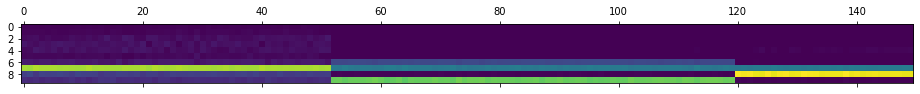

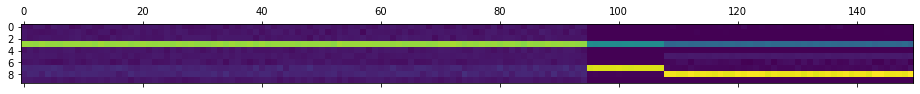

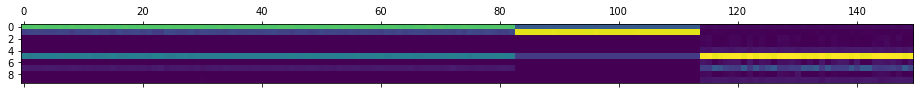

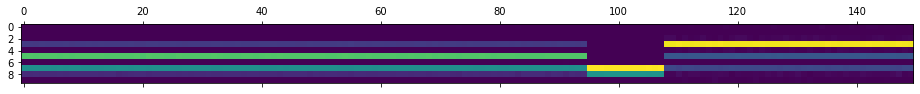

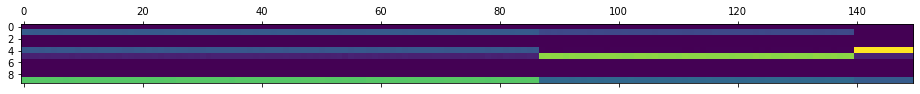

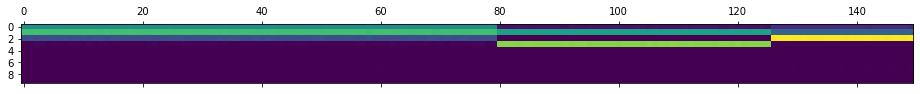

In [47]:
for l in range(d):
    plt.matshow(W_list[l].T.cpu().data)

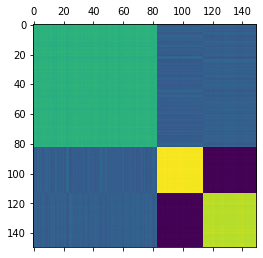

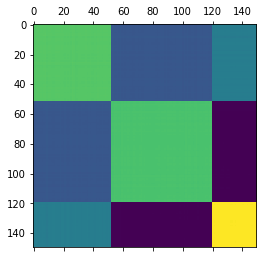

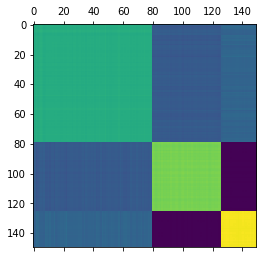

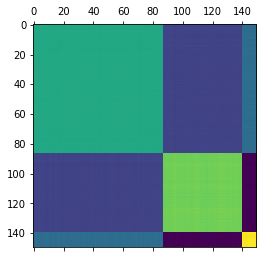

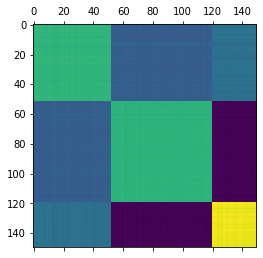

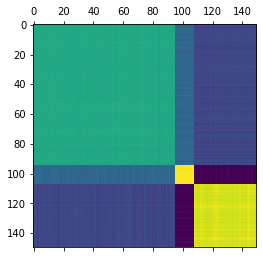

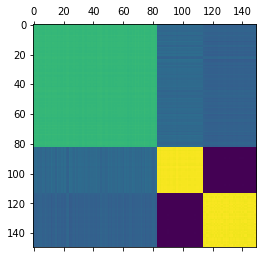

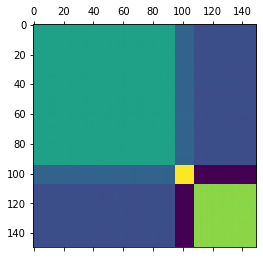

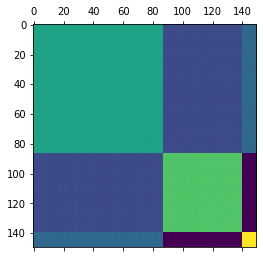

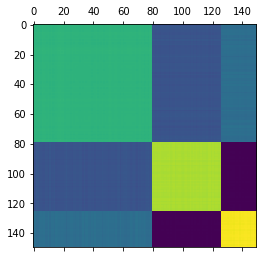

In [48]:
for l in range(d):
    plt.matshow(P_list[l].cpu().data)